In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


def parse_diskann_results(file_path):
    data = []
    with open(file_path, "r") as f:
        content = f.readlines()
        lines = content[2:]
        for l in lines:
            _, _, _, p50_latency_us, p999_latency_us, recall = l.split()
            data.append(
                {
                    "p50_latency_us": float(p50_latency_us),
                    "p999_latency_us": float(p999_latency_us),
                    "recall": float(recall),
                }
            )
    return {
        "file": file_path,
        "data": data,
    }




In [9]:
results_dir = "test_results_glibc/diskann"
settings = ["never", "madvise", "always"]                                                                                  
def get_data(results_dir: str):
    data = []
    for setting in settings:
        diskann_file = os.path.join(results_dir, f"diskann_results_{setting}.txt")
        perf_file = os.path.join(results_dir, f"diskann_perf_results_{setting}.txt")
        if not (os.path.exists(diskann_file) and os.path.exists(perf_file)):
            print(
                f"Warning: Result files for setting '{setting}' not found. Skipping."
            )
            continue
        result = {"setting": setting}
        result.update(parse_diskann_results(diskann_file))
        data.append(result)
    if not data:
        print(
            "Error: No data was parsed. Please check the 'test_results' directory."
        )
    return data
                                                                                      
glibc_data = get_data("test_results_glibc/diskann")show
tcmalloc_data = get_data("test_results_tcmalloc/diskann")


[95.07, 97.65, 98.58, 99.07, 99.35, 99.8] [112.37, 165.41, 225.26, 278.35, 328.82, 557.25] [986.73, 374.32, 513.2, 556.87, 609.44, 979.36]
[95.15, 97.71, 98.6, 99.08, 99.33, 99.79] [109.71, 163.04, 218.58, 270.99, 320.29, 542.45] [894.84, 373.82, 415.33, 519.7, 531.27, 805.47]


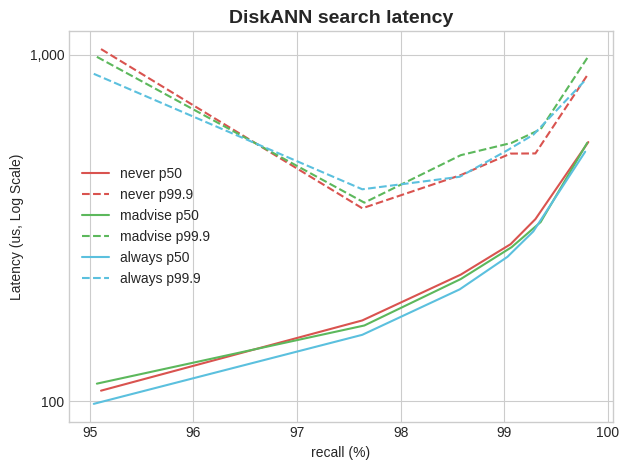

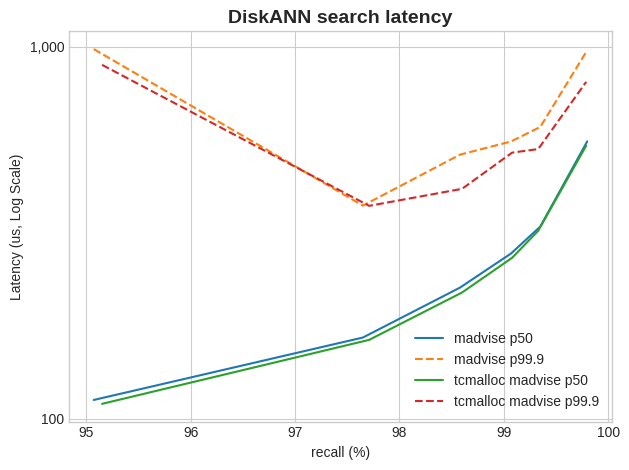

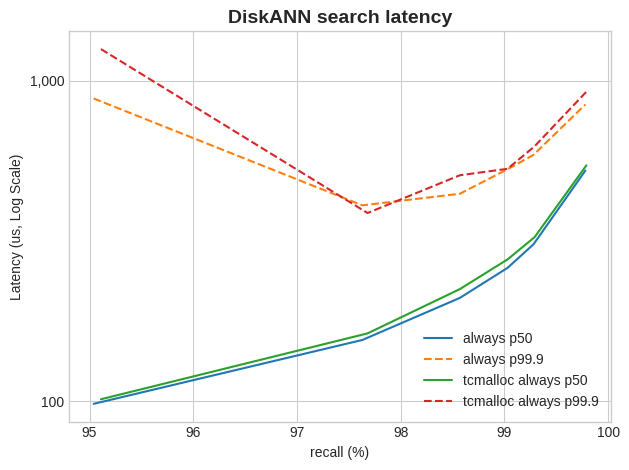

In [25]:
plt.style.use("seaborn-v0_8-whitegrid")

colors = ["#d9534f", "#5cb85c", "#5bc0de"]

plot_data = []
for data, color, setting in zip(glibc_data, colors, settings):
    p50_data = []
    p99_9_data = []
    recall = []
    for pt in data["data"]:
        p50_data.append(pt["p50_latency_us"])
        p99_9_data.append(pt["p999_latency_us"])
        recall.append(pt["recall"])
    plot_data.append({
        "label": setting,
        "p50": p50_data,
        "p99.9": p99_9_data,
        "recall": recall,
        "color": color,
    })
    
for data, color, setting in zip(tcmalloc_data, colors, settings):
    p50_data = []
    p99_9_data = []
    recall = []
    for pt in data["data"]:
        p50_data.append(pt["p50_latency_us"])
        p99_9_data.append(pt["p999_latency_us"])
        recall.append(pt["recall"])
    plot_data.append({
        "label": "tcmalloc " + setting,
        "p50": p50_data,
        "p99.9": p99_9_data,
        "recall": recall,
        "color": color,
    })
# Plot 3: dTLB Load Misses

fig3, ax3 = plt.subplots()
for pd in plot_data:
    if "tcmalloc" in pd["label"]:
        continue
    ax3.plot(pd["recall"], pd["p50"], color=pd["color"], label=pd["label"] + " p50")
    ax3.plot(pd["recall"], pd["p99.9"], color=pd["color"], label=pd["label"] + " p99.9", linestyle="dashed")
ax3.set_title("DiskANN search latency", fontsize=14, fontweight="bold")
ax3.set_ylabel("Latency (us, Log Scale)")
ax3.set_xlabel("recall (%)")
ax3.set_yscale("log")  # Use log scale due to huge difference in misses for some
ax3.legend()
ax3.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{int(y):,}"))
fig3.tight_layout()

fig4, ax4 = plt.subplots()
for pd in plot_data:
    if "madvise" not in pd["label"]:
        continue
    ax4.plot(pd["recall"], pd["p50"], label=pd["label"] + " p50")
    print(pd["recall"], pd["p50"], pd["p99.9"])
    ax4.plot(pd["recall"], pd["p99.9"], label=pd["label"] + " p99.9", linestyle="dashed")
ax4.set_title("DiskANN search latency", fontsize=14, fontweight="bold")
ax4.set_ylabel("Latency (us, Log Scale)")
ax4.set_xlabel("recall (%)")
ax4.set_yscale("log")  # Use log scale due to huge difference in misses for some
ax4.legend()
ax4.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{int(y):,}"))
fig4.tight_layout()

fig5, ax5 = plt.subplots()
for pd in plot_data:
    if "always" not in pd["label"]:
        continue
    ax5.plot(pd["recall"], pd["p50"], label=pd["label"] + " p50")
    ax5.plot(pd["recall"], pd["p99.9"], label=pd["label"] + " p99.9", linestyle="dashed")
ax5.set_title("DiskANN search latency", fontsize=14, fontweight="bold")
ax5.set_ylabel("Latency (us, Log Scale)")
ax5.set_xlabel("recall (%)")
ax5.set_yscale("log")  # Use log scale due to huge difference in misses for some
ax5.legend()
ax5.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{int(y):,}"))
fig5show.tight_layout()
plt.show()